In [21]:
import datetime
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib.plugins.sparql.parser import parseQuery
import csv
import urllib
import itertools
import json
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib import colors
import numpy
import matplotlib.pyplot as plt


In [22]:
exclude = []
exclude.append("http://www.bigdata.com/")
exclude.append("http://www.bigdata.com/")

print("read tsv file...")

# total number of queries
sample_r = []
count = 0
with open("wdlogsh.tsv") as file:
    tsv_file = csv.reader(file, delimiter="\t")
    for line in tsv_file:
        count = count + 1
        if count > 1:
            query = (
                urllib.parse.unquote_plus(line[0])
                .replace("> *", ">*")
                .replace("> / <", ">/<")
            )
            sample_r.append(query)
            # if 'http://www.bigdata.com/' not in query and 'wikibase:label' not in query:
            if count == 200001:
                break
print(len(sample_r))


def filter(x):
    return "http://www.bigdata.com" in x or "MINUS" in x


sample_no_minus = itertools.filterfalse(filter, sample_r)
sample = [x for x in sample_no_minus]
print(len(sample))


read tsv file...
100000
69970


In [23]:

def filter(x: str):
    return (">*" in x or ">+" in x or " | " in x or ">?" in x or " / " in x or "^(" in x) and ("REGEX" not in x)


rec_queries_startt = set(i for (i, e) in enumerate(sample) if filter(e))

rec_queries_all = [e for e in sample if filter(e)]

print(len(rec_queries_all))


20189


In [24]:

print(sample[741])


SELECT(  MAX ( ?var1  ) AS  ?var1  ) ?var2 
WHERE {
  BIND (  <http://www.wikidata.org/entity/Q20668858>  AS  ?var3 ).
  ?var3  <http://www.wikidata.org/prop/P1082>  ?var4 .
  ?var4  <http://www.wikidata.org/prop/statement/P1082>  ?var1 .
 OPTIONAL {
  BIND (  YEAR (  ?var5  )  AS  ?var2 ).
  ?var4  <http://www.wikidata.org/prop/qualifier/P585>  ?var5 .
 }
}
GROUP BY  ?var2 
ORDER BY ASC( ?var2 )



5000 2257
QLever 2743 (rec) max: 50.70291400000001 min: -60.0 mean: -2.8884449737513673 median: -0.04403999999999996 percent: 42.69048487057966 errors 2182 406 size: 4900
Virtuoso 2743 (rec) max: 60.0 min: -60.0 mean: -3.2587874830477577 median: -0.216066 percent: 17.790740065621584 errors 95 406 size: 4900
Blazegraph 2743 (rec) max: 1.5490800000000005 min: -60.0 mean: -3.0817071480131246 median: -0.026221000000000005 percent: 46.95588771418156 errors 5 406 size: 4900


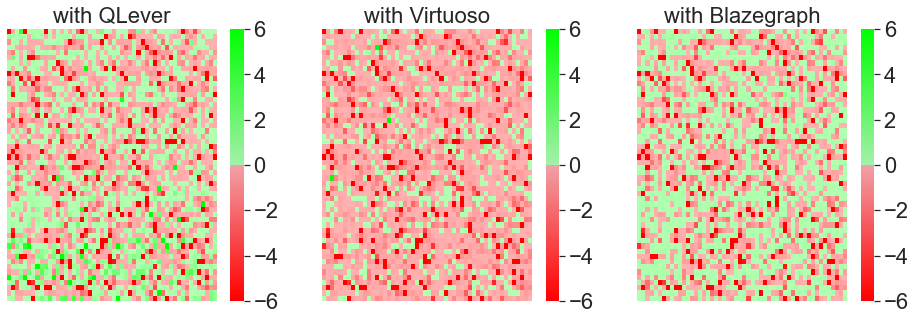

In [60]:
from math import sqrt
import math
from typing import List

CLAMP_SECONDS=6
QEP_ID = "qe"  # qe

with open("results_pre_5000.json") as f:
    data = json.load(f)


with open("query_dump_10k_valid.json") as f:
    queries = json.load(f)

qendpoint_engine = None
for engine in data["engines"]:
    eid = engine["id"]
    ename = engine["name"]
    etime = engine["time1"]
    if eid == QEP_ID:
        qendpoint_engine = engine
        qendpoint_name = ename
        break


def error_time(time: List[float], error: List[bool]) -> List[float]:
    arr = []

    i = 0

    for err in error:
        if err:
            arr.append(0)
        else:
            arr.append(time[i])
            i+=1
    return arr

if qendpoint_engine is None:
    print("qendpoint_engine is none!!!")
else:
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    fig.set_facecolor("white")
    axis_i = 0

    common_error = [False for _ in range(len(qendpoint_engine["error1"]))]

    for i in range(len(common_error)):
        a = False
        for e in data["engines"]:
            if e["error1"][i]:
                a = True
                break
        common_error[i] = a

    print(len(common_error), len([e for e in common_error if e]))

    for engine in data["engines"]:
        eid = engine["id"]
        title = engine["name"]
        error1 = engine["error1"]
        time1 = error_time(engine["time1"], error1)
        error2 = qendpoint_engine["error1"]
        time2 = error_time(qendpoint_engine["time1"], error2)

        if len(time2) != len(time1):
            print("time1!=time2 for engine", title)
            break

        if eid == QEP_ID:
            continue


        deltas_common = numpy.array(
            [(max(min(((time1[i] - time2[i]) / 1000), 60), -60) if not common_error[i] else math.nan) for i in range(0, len(time1))])

        deltas = numpy.array(
            [(max(min(((time1[i] - time2[i]) / 1000), 60), -60) if not error1[i] and not error2[i] else math.nan) for i in range(0, len(time1))])
        diff_time = numpy.array(
            [max(min(d, CLAMP_SECONDS), -CLAMP_SECONDS) for d in deltas])

        deltas2 = numpy.array(
            [max(min(e, 60), -60) for (i, e) in enumerate(deltas) if i not in rec_queries_startt])
        diff_time_rec = numpy.array(
            [max(min(d, CLAMP_SECONDS), -CLAMP_SECONDS) for d in deltas2])
        diff_time2 = numpy.array(
            [max(min(d, CLAMP_SECONDS), -CLAMP_SECONDS) for d in deltas_common])

        sq_size = int(sqrt(len(diff_time)))
        sq_size2 = int(sqrt(len(diff_time2)))

        deltas_nnan = [max(min(e, 60), -60)
                       for e in deltas_common if not math.isnan(e)]

        if len(deltas_nnan) == 0:
            print("empty deltas_nnan")
        print(
            title,
            len(deltas_nnan),
            "(rec)",
            "max:",
            numpy.max(deltas_nnan),
            "min:",
            numpy.min(deltas_nnan),
            "mean:",
            numpy.mean(deltas_nnan),
            "median:",
            numpy.median(deltas_nnan),
            "percent:",
            len([i for i in deltas_nnan if i >= 0]) / len(deltas_nnan) * 100,
            "errors",
            len([e for e in error1 if e]),
            len([e for e in error2 if e]),
            "size:", 
            sq_size2 * sq_size2
        )

        # fig = plt.figure(figsize=(12, 9))

        def get_custom_color_palette():
            map = ListedColormap(
                [
                    *[(1, 0, 0, alpha) for alpha in numpy.arange(1, 0.3, -0.01)],
                    *[(0, 1, 0, alpha) for alpha in numpy.arange(0.3, 1, 0.01)],
                ]
            )
            map.set_bad("gray")
            return map

        arr = numpy.reshape(
            diff_time[: sq_size * sq_size], (sq_size, sq_size), order="C")
        arr2 = numpy.reshape(
            diff_time2[: sq_size2 * sq_size2], (sq_size2, sq_size2), order="C")

        diff_time3 = [e for e in diff_time2 if not math.isnan(e)]
        sq_size3 = int(sqrt(len(diff_time3)))

        arr3 = numpy.reshape(
            diff_time3[: sq_size3 * sq_size3], (sq_size3, sq_size3), order="C")

        sq_size_rec = int(sqrt(len(diff_time_rec)))
        arr4 = numpy.reshape(
            diff_time_rec[: sq_size_rec * sq_size_rec], (sq_size_rec, sq_size_rec), order="C")

        
        # print(arr)
        # fig, axis = plt.subplots(figsize = (12, 9))
        # ax.hist(diff_time, bins = 200, align='mid', color='yellow', edgecolor='black', linewidth=2)
        # ax = axs[0, axis_i]
        # ax2 = axs[0, axis_i]
        ax3 = axs[axis_i]
        axis_i += 1
        # sns.heatmap(arr, cmap=get_custom_color_palette(
        # ), center=0, vmax=CLAMP_SECONDS, vmin=-CLAMP_SECONDS, ax=ax)
        # ax.set_title("time difference with " + title )
        # ax.set_axis_off()

        # sns.heatmap(arr, cmap=get_custom_color_palette(
        # ), center=0, vmax=CLAMP_SECONDS, vmin=-CLAMP_SECONDS, ax=ax2)
        # ax2.set_title("time difference with " + title, fontsize=16)
        # ax2.set_axis_off()

        sns.set(font_scale=2)
        sns.heatmap(arr3, cmap=get_custom_color_palette(), center=0,
                    vmax=CLAMP_SECONDS, vmin=-CLAMP_SECONDS, ax=ax3)
        ax3.set_title("with " + title , fontsize=22)
        ax3.set_axis_off()
    plt.savefig("values3.png", bbox_inches='tight')


In [26]:
# total number of queries


query_types = []
query_filters = []
query_triples = []
query_unions = []
query_lengthPaths = []
query_emptyPaths = []

count = 0
with open("wdlogsh_data.csv") as file:
    csv_file = csv.reader(file)
    next(csv_file)
    for line in csv_file:
        query_types.append(line[0])
        query_filters.append(int(line[1]))
        query_triples.append(int(line[2]))
        query_unions.append(int(line[3]))
        query_lengthPaths.append(int(line[4]))
        query_emptyPaths.append(int(line[5]))


print(len(query_types), len(query_filters), len(query_triples), len(query_unions), len(query_lengthPaths), len(query_emptyPaths))


10000 10000 10000 10000 10000 10000


In [27]:
tp = []
tp_fil = []
tp_union = []
rand = []

for i, (query_type, query_filter, query_triple, query_union, query_lengthPath, query_emptyPath) in enumerate(zip(
    query_types, query_filters, query_triples, query_unions, query_lengthPaths, query_emptyPaths)):

    if query_triple == 0:
        rand.append(i)
    elif query_filter + query_union + query_lengthPath + query_emptyPath == 0:
        tp.append(i)
    elif query_union + query_lengthPath + query_emptyPath == 0:
        tp_fil.append(i)
    elif query_filter + query_lengthPath + query_emptyPath == 0:
        tp_union.append(i)
    elif query_lengthPath + query_emptyPath == 0:
        tp_union.append(i)
    else:
        rand.append(i)

len(tp), len(tp_fil), len(tp_union), len(rand), sum((len(tp), len(tp_fil), len(tp_union), len(rand)))


(5285, 986, 213, 3516, 10000)

10000 4306
QLever [2017, 122, 582, 2973]
Blazegraph [2017, 122, 582, 2973]
Virtuoso [2017, 122, 582, 2973]


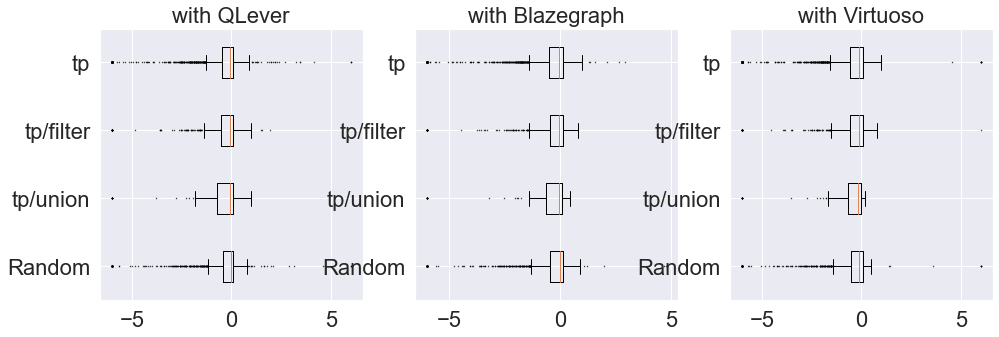

In [52]:
from math import sqrt
import math
from typing import List

CLAMP_SECONDS = 6
QEP_ID = "qe"  # qe

with open("results.json") as f:
    data = json.load(f)


with open("query_dump_10k_valid.json") as f:
    queries = json.load(f)

qendpoint_engine = None
for engine in data["engines"]:
    eid = engine["id"]
    ename = engine["name"]
    etime = engine["time1"]
    if eid == QEP_ID:
        qendpoint_engine = engine
        qendpoint_name = ename
        break


def error_time(time: List[float], error: List[bool]) -> List[float]:
    arr = []

    i = 0

    for err in error:
        if err:
            arr.append(0)
        else:
            arr.append(time[i])
            i += 1
    return arr


if qendpoint_engine is None:
    print("qendpoint_engine is none!!!")
else:
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    fig.set_facecolor("white")
    axis_i = 0

    common_error = [False for _ in range(len(qendpoint_engine["error1"]))]

    for i in range(len(common_error)):
        a = False
        for e in data["engines"]:
            if e["error1"][i]:
                a = True
                break
        common_error[i] = a

    print(len(common_error), len([e for e in common_error if e]))

    for engine in data["engines"]:
        eid = engine["id"]
        title = engine["name"]
        error1 = engine["error1"]
        time1 = error_time(engine["time1"], error1)
        error2 = qendpoint_engine["error1"]
        time2 = error_time(qendpoint_engine["time1"], error2)

        if len(time2) != len(time1):
            print("time1!=time2 for engine", title)
            break

        if eid == QEP_ID:
            continue

        deltas_common = numpy.array(
            [(max(min(((time1[i] - time2[i]) / 1000), 60), -60) if not common_error[i] else math.nan) for i in range(0, len(time1))])

        deltas = numpy.array(
            [(max(min(((time1[i] - time2[i]) / 1000), 60), -60) if not error1[i] and not error2[i] else math.nan) for i in range(0, len(time1))])
        diff_time = numpy.array(
            [max(min(d, CLAMP_SECONDS), -CLAMP_SECONDS) for d in deltas])

        deltas2 = numpy.array(
            [max(min(e, 60), -60) for (i, e) in enumerate(deltas) if i not in rec_queries_startt])
        diff_time_rec = numpy.array(
            [max(min(d, CLAMP_SECONDS), -CLAMP_SECONDS) for d in deltas2])
        diff_time2 = numpy.array(
            [max(min(d, CLAMP_SECONDS), -CLAMP_SECONDS) for d in deltas_common])

        sq_size = int(sqrt(len(diff_time)))
        sq_size2 = int(sqrt(len(diff_time2)))

        deltas_nnan = [max(min(e, 60), -60)
                       for e in deltas_common if not math.isnan(e)]

        if len(deltas_nnan) == 0:
            print("empty deltas_nnan")

        # fig = plt.figure(figsize=(12, 9))

        def get_custom_color_palette():
            map = ListedColormap(
                [
                    *[(1, 0, 0, alpha)
                      for alpha in numpy.arange(1, 0.3, -0.01)],
                    *[(0, 1, 0, alpha)
                      for alpha in numpy.arange(0.3, 1, 0.01)],
                ]
            )
            map.set_bad("gray")
            return map

        arr = numpy.reshape(
            diff_time[: sq_size * sq_size], (sq_size, sq_size), order="C")
        arr2 = numpy.reshape(
            diff_time2[: sq_size2 * sq_size2], (sq_size2, sq_size2), order="C")

        diff_time3 = [e for e in diff_time2 if not math.isnan(e)]
        sq_size3 = int(sqrt(len(diff_time3)))

        boxplot_data = [
            [diff_time2[i] for i in rand if not math.isnan(diff_time2[i])],
            [diff_time2[i] for i in tp_union if not math.isnan(diff_time2[i])],
            [diff_time2[i] for i in tp_fil if not math.isnan(diff_time2[i])],
            [diff_time2[i] for i in tp if not math.isnan(diff_time2[i])],
        ]

        boxplot_titles = [
            "Random",
            "tp/union",
            "tp/filter",
            "tp",
        ]

        print(
            title,
            [len(e) for e in boxplot_data]
        )

        ax3 = axs[axis_i]
        axis_i += 1

        bp = ax3.boxplot(boxplot_data, vert=0)

        # changing style of fliers
        for flier in bp['fliers']:
            flier.set(marker='D', markersize=0.5,
                      alpha=0.75)

        ax3.set_yticklabels(boxplot_titles)
        sns.set(font_scale=2)
        ax3.set_title("with " + title, fontsize=22)
        # ax3.set_axis_off()
    plt.savefig("values3_1.png", bbox_inches='tight')


In [63]:
from math import sqrt
import math
from typing import List

CLAMP_SECONDS = 6
QEP_ID = "qe"  # qe

with open("results_pre_5000.json") as f:
    data = json.load(f)


with open("query_dump_10k_valid.json") as f:
    queries = json.load(f)

qendpoint_engine = None
for engine in data["engines"]:
    eid = engine["id"]
    ename = engine["name"]
    etime = engine["time1"]
    if eid == QEP_ID:
        qendpoint_engine = engine
        qendpoint_name = ename
        break


def error_time(time: List[float], error: List[bool]) -> List[float]:
    arr = []

    i = 0

    for err in error:
        if err:
            arr.append(0)
        else:
            arr.append(time[i])
            i += 1
    return arr


if qendpoint_engine is None:
    print("qendpoint_engine is none!!!")
else:
    common_error = [False for _ in range(len(qendpoint_engine["error1"]))]

    for i in range(len(common_error)):
        a = False
        for e in data["engines"]:
            if e["error1"][i]:
                a = True
                break
        common_error[i] = a

    print(len(common_error), len([e for e in common_error if e]))

    best_time = dict()

    for engine in data["engines"]:
        eid = engine["id"]
        title = engine["name"]
        error1 = engine["error1"]
        time1 = error_time(engine["time1"], error1)
        error2 = qendpoint_engine["error1"]
        time2 = error_time(qendpoint_engine["time1"], error2)

        if len(time2) != len(time1):
            print("time1!=time2 for engine", title)
            break

        if eid == QEP_ID:
            continue

        deltas_common = numpy.array(
            [(max(min(((time1[i] - time2[i]) / 1000), 60), -60) if not common_error[i] else math.nan) for i in range(0, len(time1))])

        deltas = numpy.array(
            [(max(min(((time1[i] - time2[i]) / 1000), 60), -60) if not error1[i] and not error2[i] else math.nan) for i in range(0, len(time1))])
        diff_time = numpy.array(
            [max(min(d, CLAMP_SECONDS), -CLAMP_SECONDS) for d in deltas])

        deltas2 = numpy.array(
            [max(min(e, 60), -60) for (i, e) in enumerate(deltas) if i not in rec_queries_startt])
        diff_time_rec = numpy.array(
            [max(min(d, CLAMP_SECONDS), -CLAMP_SECONDS) for d in deltas2])
        diff_time2 = numpy.array(
            [max(min(d, CLAMP_SECONDS), -CLAMP_SECONDS) for d in deltas_common])

        sq_size = int(sqrt(len(diff_time)))
        sq_size2 = int(sqrt(len(diff_time2)))

        deltas_nnan = [max(min(e, 60), -60)
                       for e in deltas_common if not math.isnan(e)]

        if len(deltas_nnan) == 0:
            print("empty deltas_nnan")

        # fig = plt.figure(figsize=(12, 9))

        def get_custom_color_palette():
            map = ListedColormap(
                [
                    *[(1, 0, 0, alpha)
                      for alpha in numpy.arange(1, 0.3, -0.01)],
                    *[(0, 1, 0, alpha)
                      for alpha in numpy.arange(0.3, 1, 0.01)],
                ]
            )
            map.set_bad("gray")
            return map

        arr = numpy.reshape(
            diff_time[: sq_size * sq_size], (sq_size, sq_size), order="C")
        arr2 = numpy.reshape(
            diff_time2[: sq_size2 * sq_size2], (sq_size2, sq_size2), order="C")

        diff_time3 = [e for e in diff_time2 if not math.isnan(e)]
        sq_size3 = int(sqrt(len(diff_time3)))

        # boxplot_data = [
        #     [diff_time2[i] for i in rand if not math.isnan(diff_time2[i])],
        #     [diff_time2[i] for i in tp_union if not math.isnan(diff_time2[i])],
        #     [diff_time2[i] for i in tp_fil if not math.isnan(diff_time2[i])],
        #     [diff_time2[i] for i in tp if not math.isnan(diff_time2[i])],
        # ]

        sort_queries = [(sample[i], deltas_common[i])
                        for i in tp if i < 5000 and not math.isnan(deltas_common[i])]
        sort_queries.sort(key=lambda x: x[1])

        best_time[eid] = sort_queries

    with open("best_10K.json", "w") as f:
        json.dump(best_time, f, indent=2)


5000 2257


In [79]:
with open("results_global.json") as f:
    data = json.load(f)

qlever = next((e for e in data["engines"] if e["id"] == "ql"))

qlever_error1 = qlever["error1"]

queries = [sample[i] for i, err in enumerate(qlever_error1) if err]

In [77]:

### RUN ERRORED QUERY OF QLEVER

# sp = SPARQLWrapper(
#     "https://qlever.cs.uni-freiburg.de/api/wikidata",
#     agent="D063520 (https://the-qa-company.com/; dennis.diefenbach@the-qa-company.com)",
# )

# good = []
# count = 0
# for q in queries:
#     count += 1
#     if count % 100 == 0:
#         print(count)
#     try:
#         sp.setQuery(q + "")
#         ret = sp.queryAndConvert()
#         print("done???")
#     except Exception as e:
#         err = str(e)
#         if not ("QueryBadFormed" in err):
#             good.append(q)
#             break



100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100


In [92]:
with open("results_global.json") as f:
    data = json.load(f)

wdata = next((e for e in data["engines"] if e["id"] == "vs"))

wdata_error1 = wdata["error1"]

queries = [sample[i] for i, err in enumerate(wdata_error1) if err]
print(len(queries))

sp = SPARQLWrapper(
    # "http://query.wikidata.org/sparql",
    "https://wikidata.demo.openlinksw.com/sparql",
    agent="D063520 (https://the-qa-company.com/; dennis.diefenbach@the-qa-company.com)",
)

good = []
count = 0
for q in queries:
    count += 1
    if count % 100 == 0:
        print(count)
    try:
        sp.setQuery(q + "")
        sp.setTimeout(10)
        ret = sp.queryAndConvert()
        print("done???")
        break
    except Exception as e:
        err = str(e)
        if not ("b'Virtuoso 22007 Error" in err):
            good.append(q)
            print(err)
            break


147
The read operation timed out


In [97]:
with open("results_global.json") as f:
    data = json.load(f)

wdata = next((e for e in data["engines"] if e["id"] == "wd"))

wdata_error1 = wdata["error1"]

queries = [sample[i] for i, err in enumerate(wdata_error1) if err]
print(len(queries))

sp = SPARQLWrapper(
    "http://query.wikidata.org/sparql",
    agent="D063520 (https://the-qa-company.com/; dennis.diefenbach@the-qa-company.com)",
)

good = []
bad = []
count = 0
for q in queries:
    count += 1
    if count % 100 == 0:
        print(count)
    try:
        sp.setQuery(q + "")
        sp.setTimeout(10)
        ret = sp.queryAndConvert()
        print("done???")
    except Exception as e:
        err = str(e)
        if not ("StackOverflow" in err):
            good.append(q)
            print(err)
        else:
            bad.append(q)


11


In [96]:
print(bad[0])

SELECT ?var1 ( COUNT ( ?var2  ) AS  ?var3  )
WHERE {
  ?var2  <http://www.wikidata.org/prop/direct/P31>  <http://www.wikidata.org/entity/Q5> .
  ?var2  <http://www.wikidata.org/prop/direct/P106>  ?var1 .
  ?var2  <http://www.wikidata.org/prop/direct/P21>  <http://www.wikidata.org/entity/Q6581072> .
}
GROUP BY  ?var1 
ORDER BY  DESC( ?var3 )

